<a href="https://colab.research.google.com/github/YuyaIwamoto55/Kaggle-Walmart-2014/blob/main/walmart_model1_WMAE_1515_RFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walmart Recruiting - Store Sales Forecasting
Use historical markdown data to predict store sales

# Ⅰ. プロジェクトの流れ
**【目的】**  
**アメリカのウォルマート４５店舗の売上データや店舗データ、プロモーションデータ（値下げ、販促用のマークダウンデータなど）をもとに売上予測モデルを作成する。さらにProminent HolidayでのMarkdownの効果も兼ねた予測モデルも作成する。**  
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting  

-

**【流れ】**
 - ①データの確認：欠損・ノイズ確認、必要な変数追加
 - ②データの準備：データ結合、欠損値確認
 - ③データ可視化・探索（EDA）：基本統計量、分布、目的変数との傾向（散布図、ヒストグラム、箱ひげ）や相関係数、モデル決定
 - ④データの前処理、売上予測モデル（回帰）を作成
 - ⑤モデルの検証：評価とパラメーター最適化

-


**【データセット】 目的変数を'Weekly_Sales'として、モデリングを行っていく。**
 - stores.csv：**店舗ナンバー**、サイズ
 - train.csv：**店舗ナンバー**、部門ナンバー、**日時（週）**、週毎の売上、ホリデイかどうか
 - features.csv:**店舗ナンバー**、**日時（週）**、温度、燃料の料金、MarkDown1-5（販促管理コード）、CPI（消費者物価指数）、失業率、ホリデイかどうか
 - test.csv:店舗ナンバー、部門ナンバー、日時（週）、ホリデイかどうか

-

【前情報】
 - 売上データは2010-02-05 to 2012-11-01
 - MarkDownデータはは2011年11月〜
 - データには欠落したデータが一部ある。「NA」と記録
 - 出題者が重要だと感じるprominent holidayは以下に記載。 データの"IsHoliday"は以下を示しているわけではなく、通常の休日を示す。
   - Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
   - Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
   - Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
   - Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

---
# Ⅱ. 分析

### 1.データの確認
用意されたデータの確認を行う。
  - features.csv.zip
  - stores.csv
  - test.csv.zip
  - train.csv.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "/content/drive/My Drive/self-employed/20210517_walmart"

/content/drive/My Drive/self-employed/20210517_walmart


In [3]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [4]:
path = os.getcwd()

print(path)

/content/drive/My Drive/self-employed/20210517_walmart


#### stores.csv
サイズ、欠損値、基本統計量

In [5]:
df_store = pd.read_csv("walmart-recruiting-store-sales-forecasting/stores.csv")

print(" ")
print("【stores.csv】--------------------")
print(" ")
print(df_store.head(5))

print(" ")
print("→　データの形は、",df_store.shape,"です")
print(" ")
print("〜〜基本統計量〜〜")
print(df_store.describe())
print(" ")
print("〜〜欠損値〜〜")
print(df_store.isnull().sum())
print("--------------------------------")

 
【stores.csv】--------------------
 
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
 
→　データの形は、 (45, 3) です
 
〜〜基本統計量〜〜
           Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000
 
〜〜欠損値〜〜
Store    0
Type     0
Size     0
dtype: int64
--------------------------------


In [6]:
df_store['Store'].nunique()

45

In [7]:
# レコード数とStoreのユニークなID数が等しいことを確認。Store IDは正しく記載されていることがわかる。
print(len(df_store) == df_store['Store'].nunique())

True


#### train.csv

In [8]:
df_train = pd.read_csv("walmart-recruiting-store-sales-forecasting/train.csv.zip")

print(" ")
print("【train.csv】--------------------")
print(" ")
print(df_train.head(5))

print(" ")
print("→　データの形は、",df_train.shape,"です")
print(" ")
print("〜〜基本統計量〜〜")
print(df_train.describe())
print(" ")
print("〜〜欠損値〜〜")
print(df_train.isnull().sum())
print("--------------------------------")

 
【train.csv】--------------------
 
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
 
→　データの形は、 (421570, 5) です
 
〜〜基本統計量〜〜
               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000
 
〜〜欠損値〜〜
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
--------------------------------


#### test.csv

In [9]:
df_test = pd.read_csv("walmart-recruiting-store-sales-forecasting/test.csv.zip")

print(" ")
print("【test.csv】--------------------")
print(" ")
print(df_test.head(5))

print(" ")
print("→　データの形は、",df_test.shape,"です")
print(" ")
print("〜〜基本統計量〜〜")
print(df_test.describe())
print(" ")
print("〜〜欠損値〜〜")
print(df_test.isnull().sum())
print("--------------------------------")

 
【test.csv】--------------------
 
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
 
→　データの形は、 (115064, 4) です
 
〜〜基本統計量〜〜
               Store           Dept
count  115064.000000  115064.000000
mean       22.238207      44.339524
std        12.809930      30.656410
min         1.000000       1.000000
25%        11.000000      18.000000
50%        22.000000      37.000000
75%        33.000000      74.000000
max        45.000000      99.000000
 
〜〜欠損値〜〜
Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64
--------------------------------


#### features.csv
'IsHoliday'はmergeの際にtrainデータとtestデータを被ってしまうので削除する。

In [10]:

df_f = pd.read_csv("walmart-recruiting-store-sales-forecasting/features.csv.zip")

print(" ")
print("【features.csv】--------------------")
print(" ")
print(df_f.head(5))

print(" ")
print("→　データの形は、",df_f.shape,"です")
print(" ")
print("〜〜基本統計量〜〜")
print(df_f.describe())
print(" ")
print("〜〜欠損値〜〜")
print(df_f.isnull().sum())
print("--------------------------------")

 
【features.csv】--------------------
 
   Store        Date  Temperature  ...         CPI  Unemployment  IsHoliday
0      1  2010-02-05        42.31  ...  211.096358         8.106      False
1      1  2010-02-12        38.51  ...  211.242170         8.106       True
2      1  2010-02-19        39.93  ...  211.289143         8.106      False
3      1  2010-02-26        46.63  ...  211.319643         8.106      False
4      1  2010-03-05        46.50  ...  211.350143         8.106      False

[5 rows x 12 columns]
 
→　データの形は、 (8190, 12) です
 
〜〜基本統計量〜〜
             Store  Temperature  ...          CPI  Unemployment
count  8190.000000  8190.000000  ...  7605.000000   7605.000000
mean     23.000000    59.356198  ...   172.460809      7.826821
std      12.987966    18.678607  ...    39.738346      1.877259
min       1.000000    -7.290000  ...   126.064000      3.684000
25%      12.000000    45.902500  ...   132.364839      6.634000
50%      23.000000    60.710000  ...   182.764003      7.806

In [11]:
pd.DataFrame(df_f.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


In [12]:
df_f_bool = (df_f == 'NA')

print("Data Descriptionより、欠損値が「NA」でマークされているということで文字列「NA」を含むMarkDown1~5があるかを確認→",print(df_f_bool.sum()))
print("文字列のNAではなく、NaNとして欠損値が表示されることを確認")

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64
Data Descriptionより、欠損値が「NA」でマークされているということで文字列「NA」を含むMarkDown1~5があるかを確認→ None
文字列のNAではなく、NaNとして欠損値が表示されることを確認


結論  
  - train.csvは約42万レコード、Features.csvは約8500レコード
    train.csvのsalesでmin:-4000, max:693099.360000 と外れ値の可能性がある。精度によっては、工夫が必要。  
  - "Data"の型がobject型になっているので、加工の際にdate型（週、年）にして１年間の動きを見れるようにする。また、記載の日時は金曜日であることから週売上の締めが金曜日であることが予想できる。  
  - 欠損値はfeatures.csvの「MarkDown1~5」に約半数ずつ存在している。  

それでは、データ処理に移る。

## 2.データの準備
まずはtrainデータにstoreデータ+featuresデータをinner joinさせ、mergeした  
Dataの型が、objectになっているので、加工の際にdate型（週、年）にして１年間の動きを見れるようにする。  
データの特徴・傾向をみる.

In [13]:
%%time
df = df_train.merge(df_store, on="Store", how='inner').merge(df_f, on=["Store", "Date", "IsHoliday"], how='inner')
df.shape

CPU times: user 127 ms, sys: 30.8 ms, total: 158 ms
Wall time: 163 ms


In [14]:
print(" ")
print("【dfのデータフレーム】--------------------")
print(" ")
print(df.head(5))

print(" ")
print("→　データの形は、",df.shape,"です")
print(" ")
print("〜〜基本統計量〜〜")
print(df.describe())
print(" ")
print("〜〜欠損値〜〜")
print(df.isnull().sum())
print("--------------------------------")

 
【dfのデータフレーム】--------------------
 
   Store  Dept        Date  ...  MarkDown5         CPI Unemployment
0      1     1  2010-02-05  ...        NaN  211.096358        8.106
1      1     2  2010-02-05  ...        NaN  211.096358        8.106
2      1     3  2010-02-05  ...        NaN  211.096358        8.106
3      1     4  2010-02-05  ...        NaN  211.096358        8.106
4      1     5  2010-02-05  ...        NaN  211.096358        8.106

[5 rows x 16 columns]
 
→　データの形は、 (421570, 16) です
 
〜〜基本統計量〜〜
               Store           Dept  ...            CPI   Unemployment
count  421570.000000  421570.000000  ...  421570.000000  421570.000000
mean       22.200546      44.260317  ...     171.201947       7.960289
std        12.785297      30.492054  ...      39.159276       1.863296
min         1.000000       1.000000  ...     126.064000       3.879000
25%        11.000000      18.000000  ...     132.022667       6.891000
50%        22.000000      37.000000  ...     182.318780       7.86

### 表結合後の欠損値と欠損値処理
MarkDown1~5には、半数以上の欠損値が含まれることがわかる。理由としては、
  - MarkDownの記載は2011年11月以降であるため
  - 2011年11月以降もNaNは存在するため  

以上より、欠損値処理を行う場合は、
  - **2011年11月より前に関しては、MarkDownと休日とWeeklySalesがどの程度相関があるかで、どんな処理を行うか決めたい。**
  - 2011年11月以降、MarkDown1-5の欠損値には中央値を代入

In [15]:
# 'Date'をData型に変更し、'Week'と'Year'の二つのカラムを作成する。
df['Date'] = pd.to_datetime(df['Date'])

df['Week'] = df['Date'].dt.week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [16]:
print("df['Date']のデータ型は、", df['Date'].dtypes)
print("df['Week']のデータ型は、", df['Week'].dtypes)
print("df['Month']のデータ型は、", df['Month'].dtypes)
print("df['Year']のデータ型は、", df['Year'].dtypes)

df['Date']のデータ型は、 datetime64[ns]
df['Week']のデータ型は、 int64
df['Month']のデータ型は、 int64
df['Year']のデータ型は、 int64


In [17]:
df['Date']

0        2010-02-05
1        2010-02-05
2        2010-02-05
3        2010-02-05
4        2010-02-05
            ...    
421565   2012-10-26
421566   2012-10-26
421567   2012-10-26
421568   2012-10-26
421569   2012-10-26
Name: Date, Length: 421570, dtype: datetime64[ns]

In [18]:
df['Week'].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  1,  2,  3,
        4])

In [19]:
df['Month'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1])

In [20]:
df['Year'].unique()

array([2010, 2011, 2012])

### MarkDownの欠損値について
2021/11/01以降のMarkdown1-5の欠損値を確認すると、2011-11-04のレコードとNaNが確認できる。  
2011年11月以降のMarkDown内の欠損値処理は、平均値・中央値の代入などの処理を行う必要がある。

In [21]:
%%time
print(df.query("Date >= '2011-11-01' & Date <= '2012-3-31' & Store == '1' & Dept == '1'")
      .filter(items=['Store', 'Dept', 'Date', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis='columns'))

      Store  Dept       Date  ...  MarkDown3  MarkDown4  MarkDown5
6515      1     1 2011-11-04  ...        NaN        NaN        NaN
6587      1     1 2011-11-11  ...     215.07    2406.62    6551.42
6659      1     1 2011-11-18  ...      51.98     427.39    5988.57
6731      1     1 2011-11-25  ...   55805.51       8.00     554.92
6804      1     1 2011-12-02  ...    1398.11    2084.64   20475.32
6877      1     1 2011-12-09  ...     105.02    3639.42   14461.82
6950      1     1 2011-12-16  ...     347.37     225.79    4011.37
7022      1     1 2011-12-23  ...     634.70      24.90    2739.43
7096      1     1 2011-12-30  ...     260.36     983.65    4735.78
7169      1     1 2012-01-06  ...     143.10    1450.13    8483.00
7241      1     1 2012-01-13  ...      42.24     453.08    3719.38
7312      1     1 2012-01-20  ...      33.88     500.62    3400.21
7385      1     1 2012-01-27  ...      44.00      11.00    1222.19
7455      1     1 2012-02-03  ...     160.53   32403.87    563

In [22]:
pd.DataFrame(df.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Date,datetime64[ns]
Weekly_Sales,float64
IsHoliday,bool
Type,object
Size,int64
Temperature,float64
Fuel_Price,float64
MarkDown1,float64


## 3.データ可視化
 1. 変数の分析（離散・連続データ）、各変数とWeekly_Salesとの相関関係：
 2. Weekly_Salesの推移：年・月・週データと'Weekly_Sales'の関係
 3. 店舗・部門ごとのDateの’week'と’year’を用いた週間Weekly_Salesの年推移
 4. 新しく追加したカラムを含めた全カラムとWeekly_Salesの相関関係
 5. まとめ

---
### 1.変数の分析：

In [23]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=df.Weekly_Sales, x=df[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Weekly_Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=df.Weekly_Sales, x=df[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Weekly_Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [24]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=df['Weekly_Sales'], 
                        x=boxcox1p(df[feature], 0.15),
                        ax=fig.add_subplot(gs[0,1]),
                        palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(df['Weekly_Sales'].corr(boxcox1p(df[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(df[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=df['Weekly_Sales'], 
                        x=boxcox1p(df[feature], 0.25), 
                        ax=fig.add_subplot(gs[1,0]), 
                        palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(df['Weekly_Sales'].corr(boxcox1p(df[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(df[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(df[feature], 
                     ax=fig.add_subplot(gs[1,1]), 
                     color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=df['Weekly_Sales'], 
                        x=df[feature], 
                        ax=fig.add_subplot(gs[0,0]), 
                        color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(df['Weekly_Sales'].corr(df[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(df[feature], nan_policy='omit'),2)))
    
    fig.show()

#### 1.離散データの分析

---
Weekly_Sales x IsHoliday

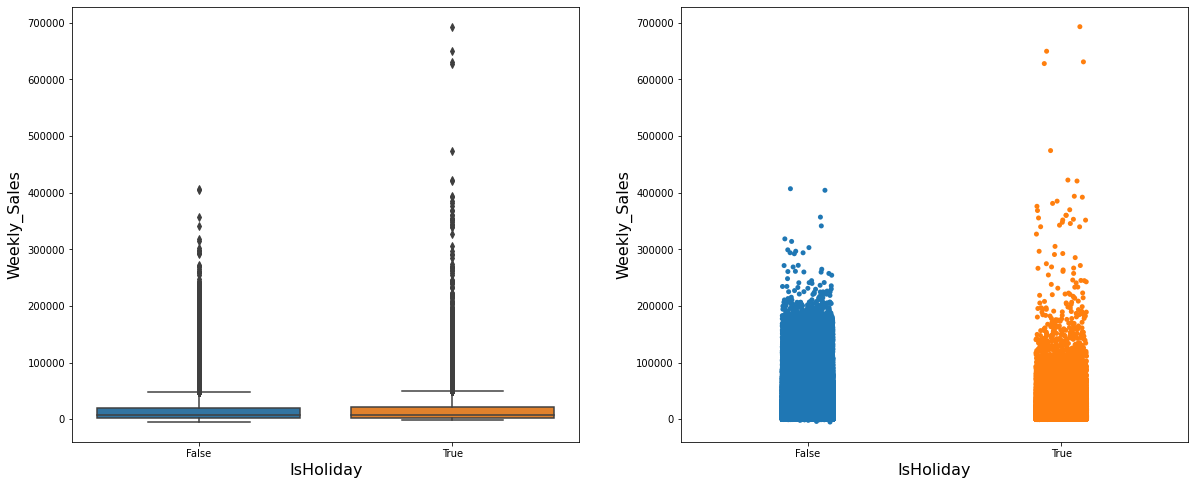

In [25]:
make_discrete_plot('IsHoliday')

休日である方が売り上げが高い傾向にあることがわかるが大きな差はない。

---
Weekly_Sales x Type

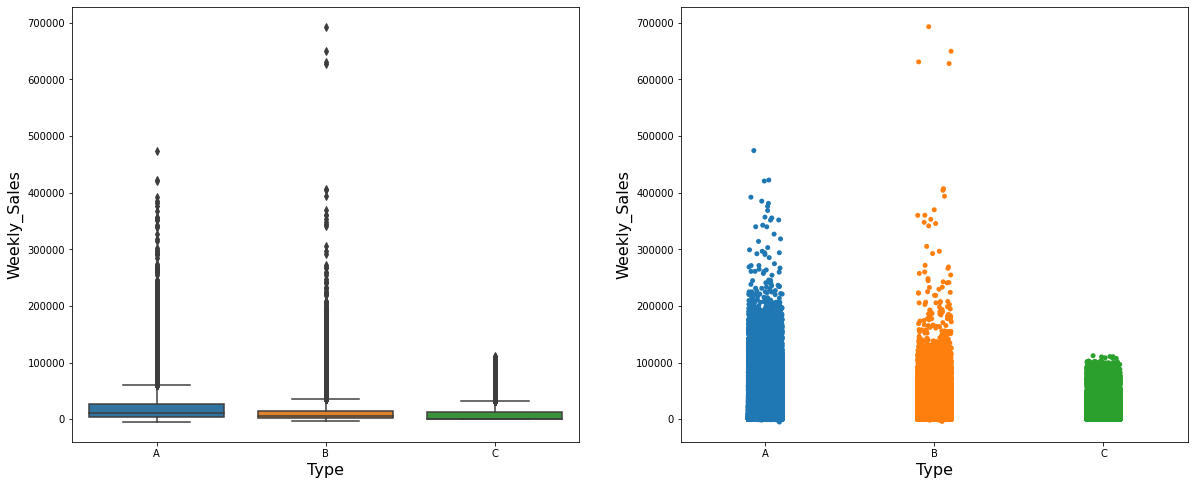

In [26]:
make_discrete_plot('Type')

---
Typeによって、売上の傾向が見える。  TypeBが大きな売り上げ週がいくつかあるが、中央値を見るとA,B,Cの順で大きいことがわかり、Typeは重要な特徴量であることがわかる。  

現在、object値なので、ランダムフォレストに入れる際は、ラベル付、もしくはone-hot encodingする。

---
#### 2.連続データの分析

・TemperatureとWeekly_Sales

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


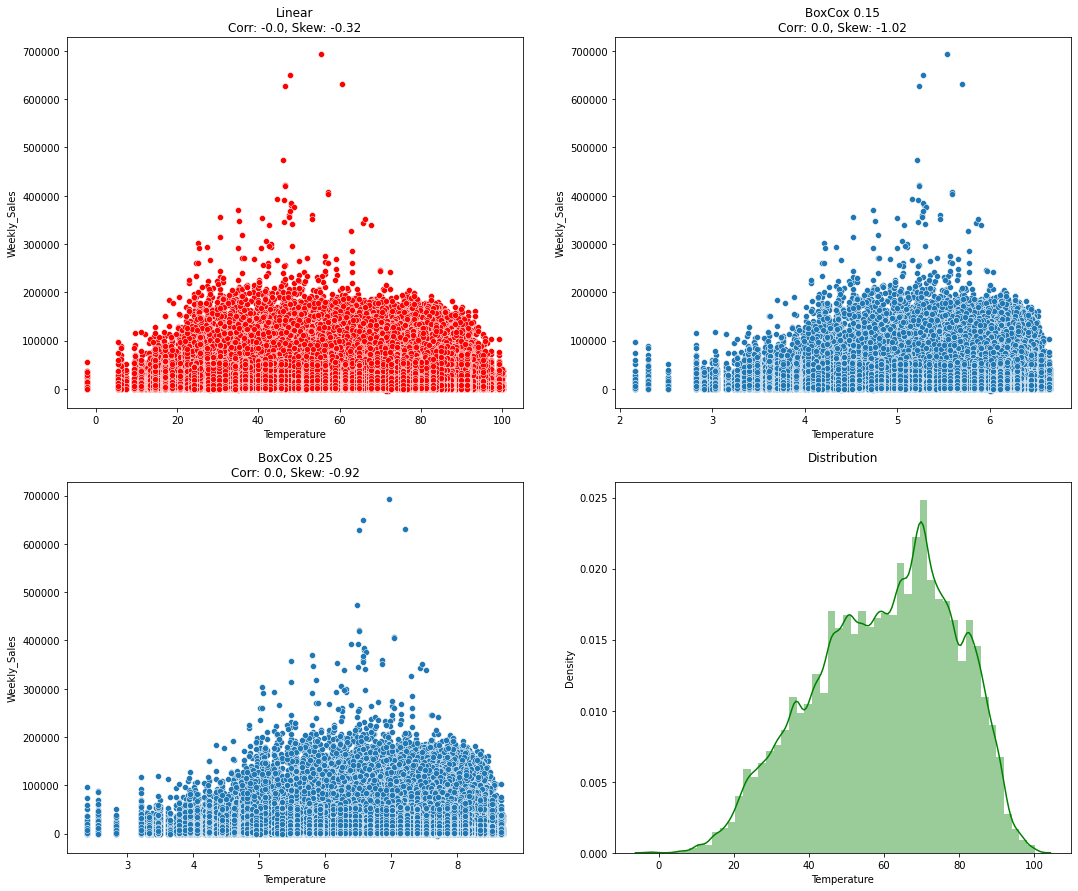

In [27]:
make_continuous_plot('Temperature')

考察：温度とWeekly_Salesも相関0。華氏５０度（摂氏約４度）あたりに最高売上が来ていることから、冬に売り上げが高いことがわかる。特徴量としては、日付を表すデータがあれば必要ない。


---
・Weekly_Sales と CPI

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


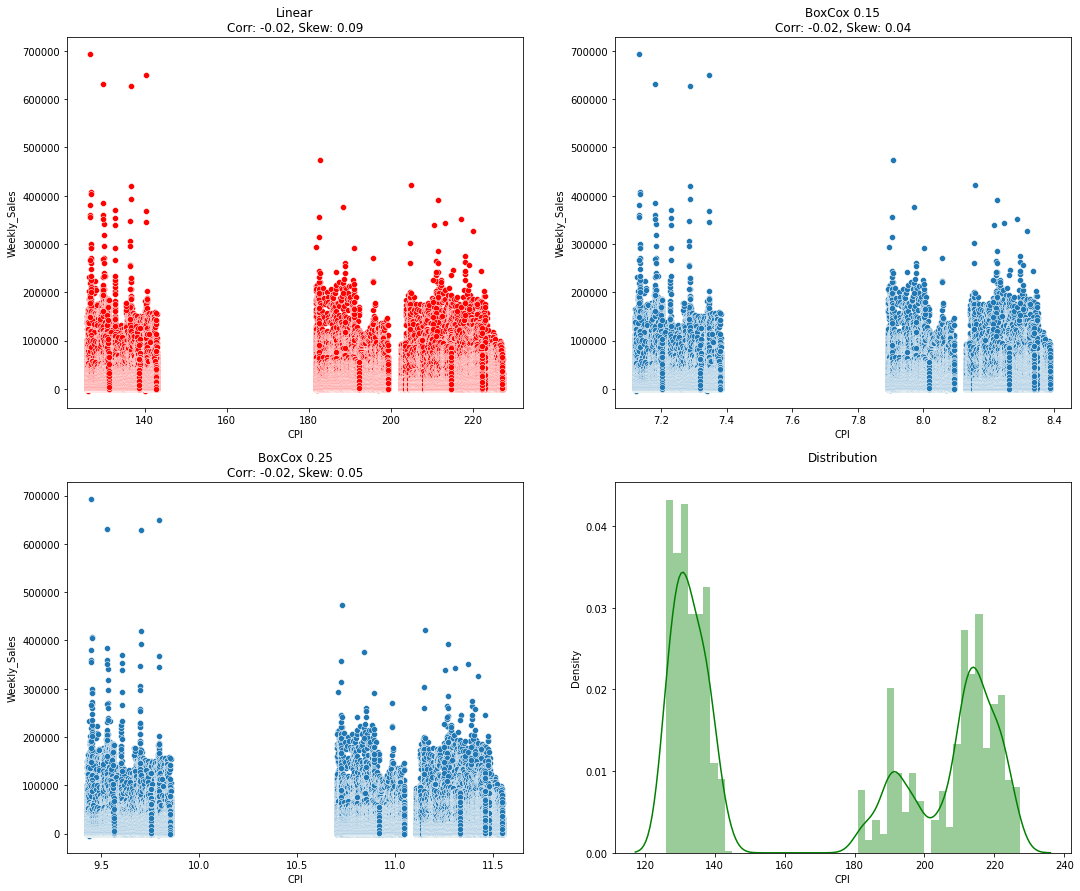

In [28]:
make_continuous_plot('CPI')

考察:相関はない。さらにプロットも途切れているため、新たなデータの予測には使いづらいため、特徴料として削除する。  
CPIは2010年から2012年にかけて約4％の急成長しているため、このようなデータになっている可能性もある。  
https://en.wikipedia.org/wiki/United_States_Consumer_Price_Index

---
Weekly_Sales x Unemployment

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


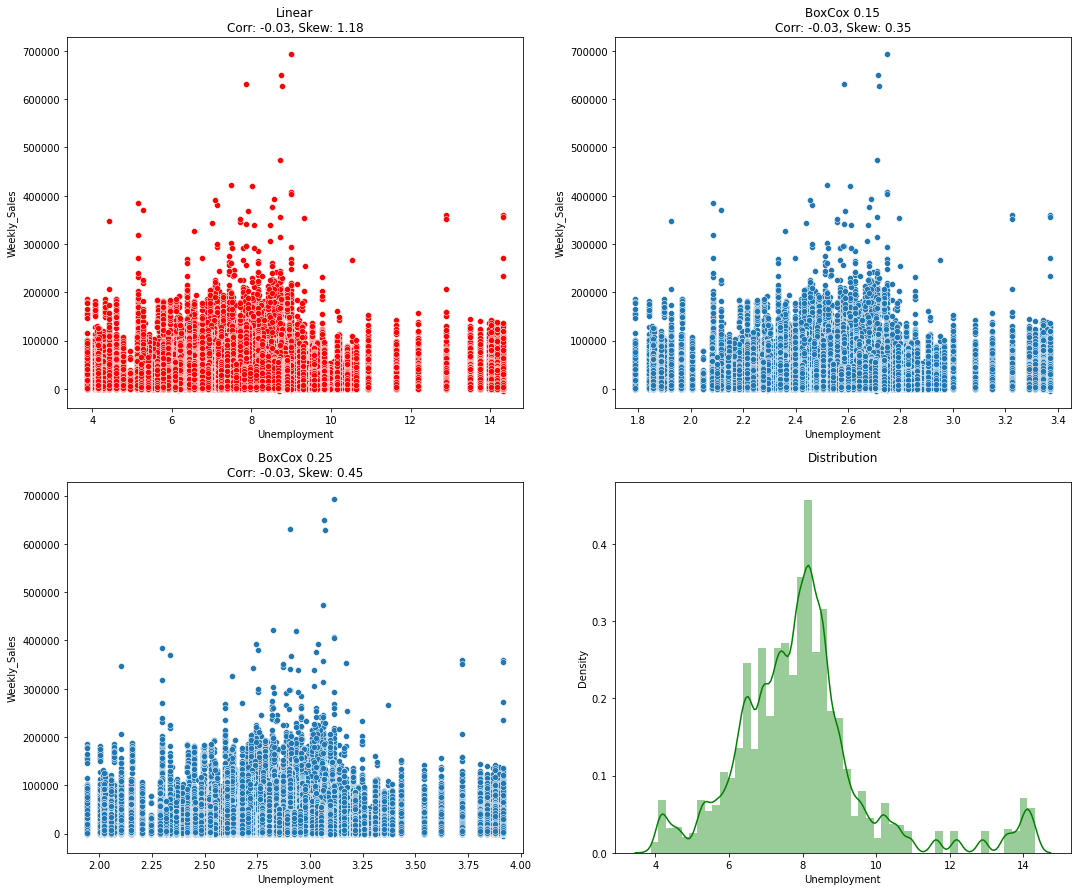

In [29]:
make_continuous_plot('Unemployment')

考察

---
Weekly_Sales x Size

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


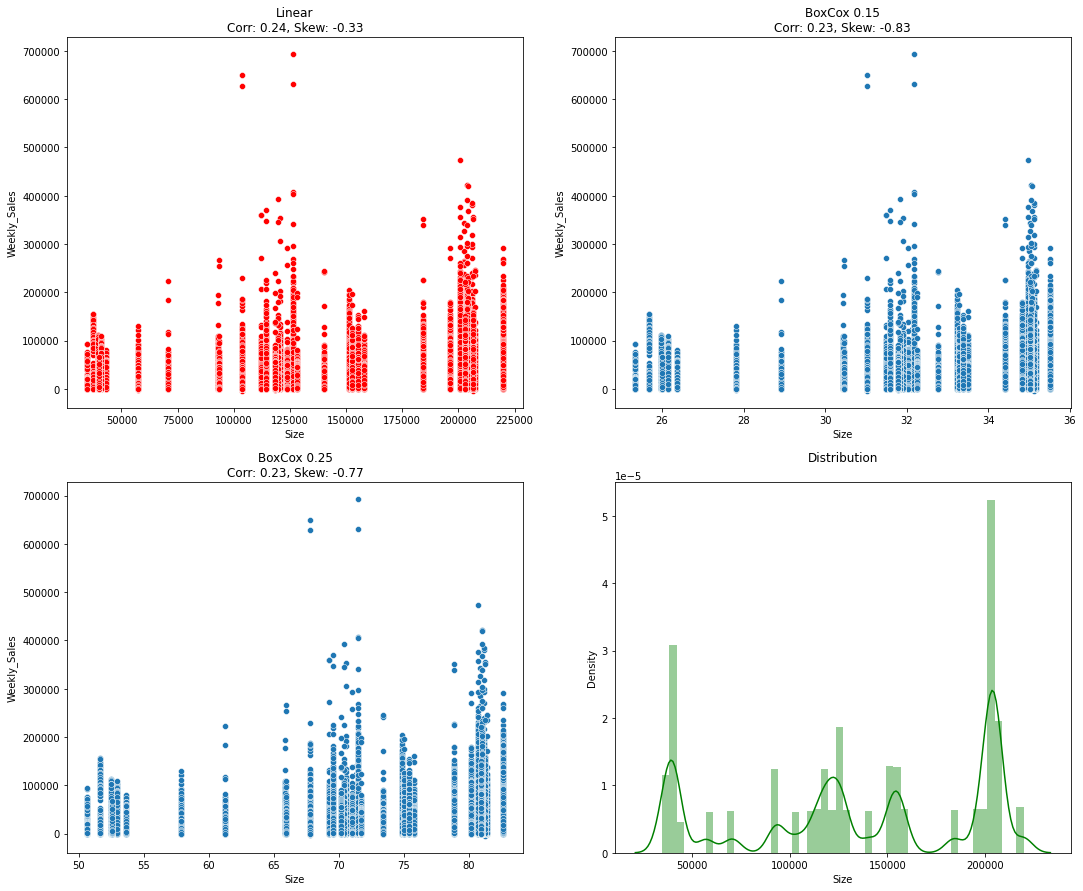

In [30]:
make_continuous_plot('Size')

考察：店舗サイズ'Size'との相関係数0.24と他の特徴よりも高いため、モデリングには必須。

---
Weekly_Sales x Fuel_Price

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


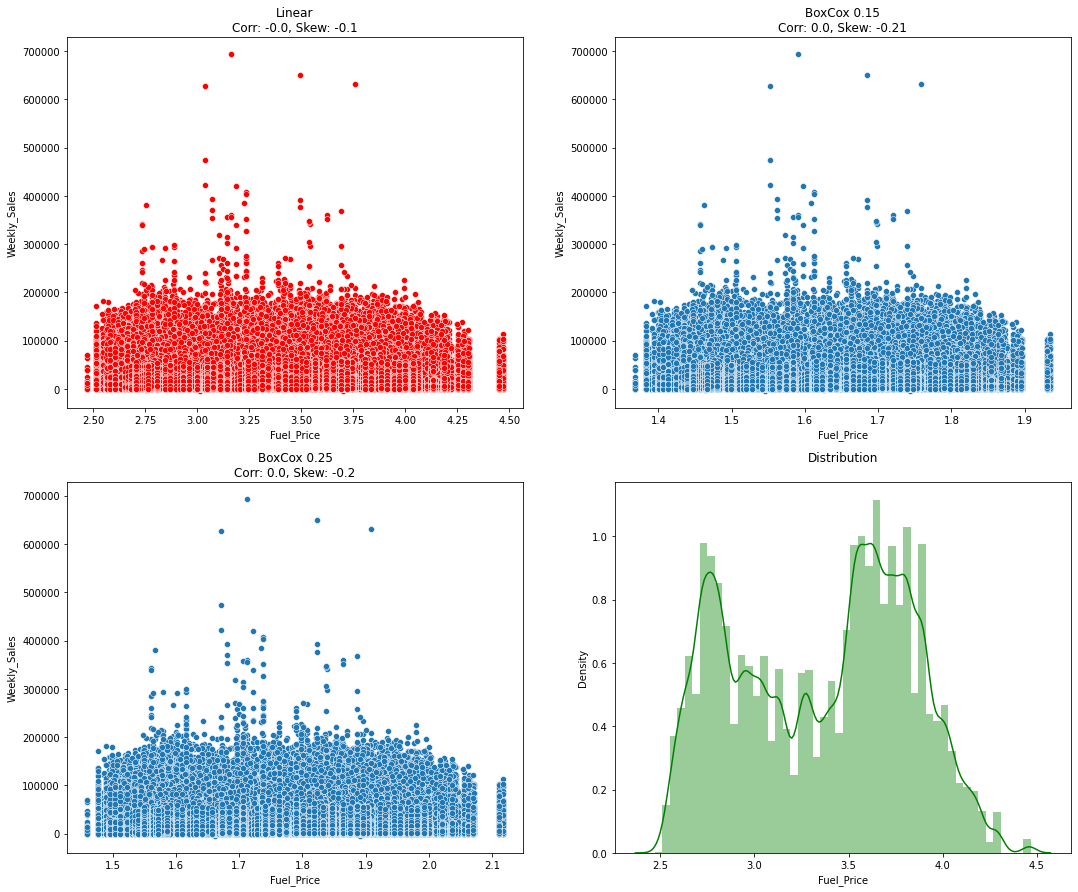

In [31]:
make_continuous_plot('Fuel_Price')

Fuel_Priceについて  
Weekly＿Salesとの相関Corr=０。さらに右下の密度分布で3.0~3.5の間に２つの山ができてしまっている。燃料値幅は、不規則に変化していくので今回の2年分のデータでは関係性が見えにくいのではないかと考え、特徴量として適切ではないことも考える。
http://theamericanenergynews.com/energy-news/us-gasoline-prices-this-thanksgiving-are-lowest-in-7-years

---
Weekly_Sales x MarkDown1

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


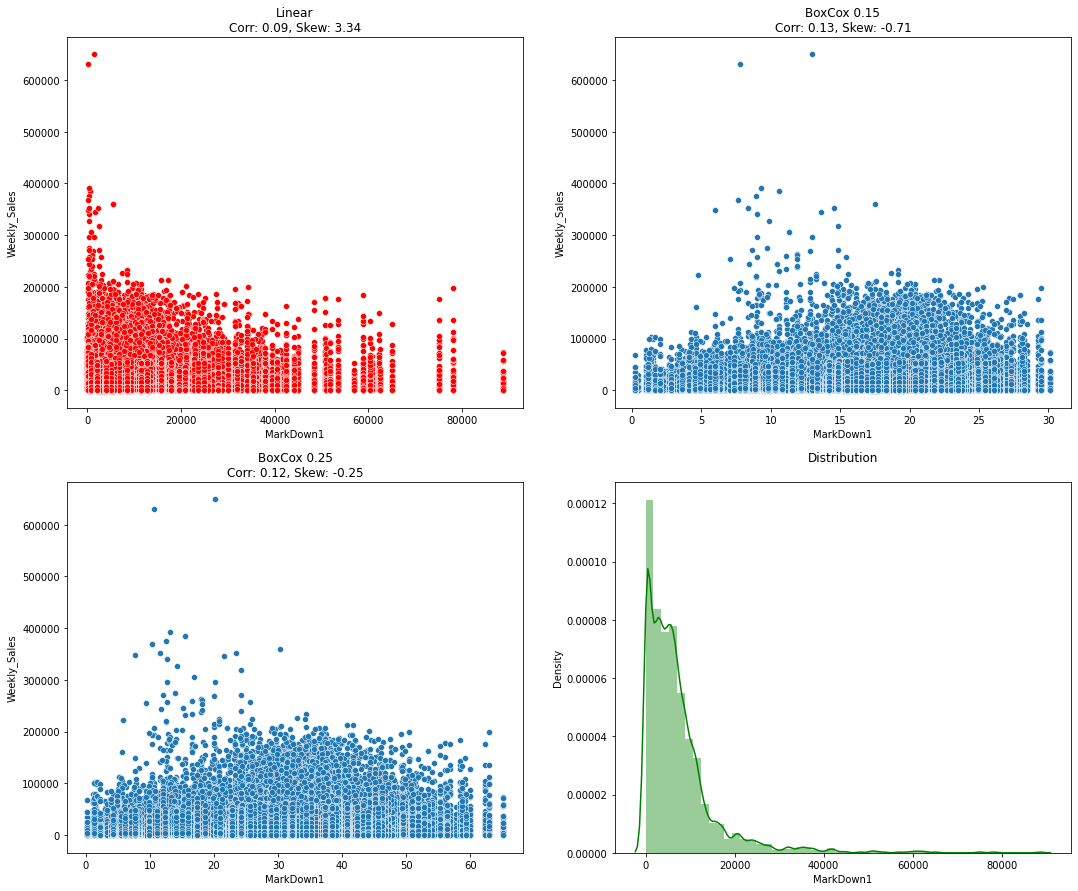

In [32]:
make_continuous_plot('MarkDown1')

欠損値によってしまっているので、MarkDown1を利用したモデリングの際は欠損値削除してから、再度分布を確認し、分布調整のための変数変換を行う。

---
Weekly_Sales x MarkDown2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


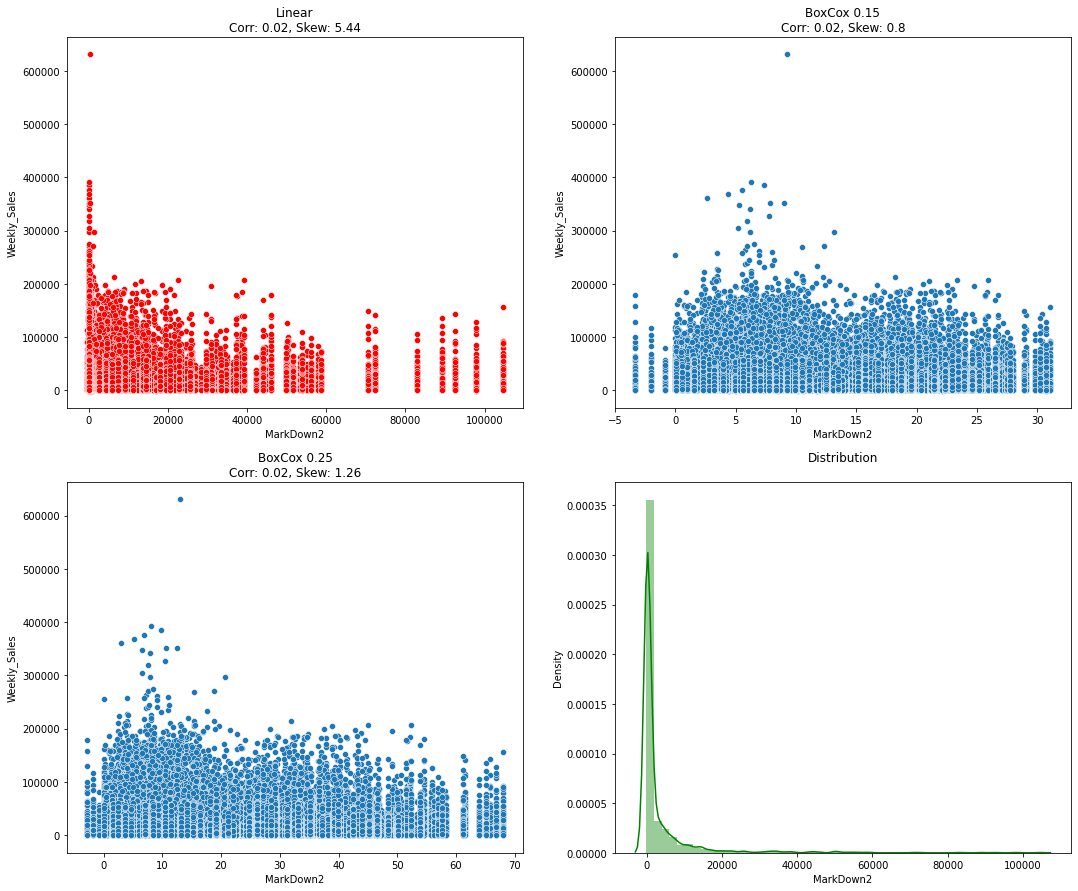

In [33]:
make_continuous_plot('MarkDown2')

MarkDown1と同様

---
Weekly_Sales x MarkDown3

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


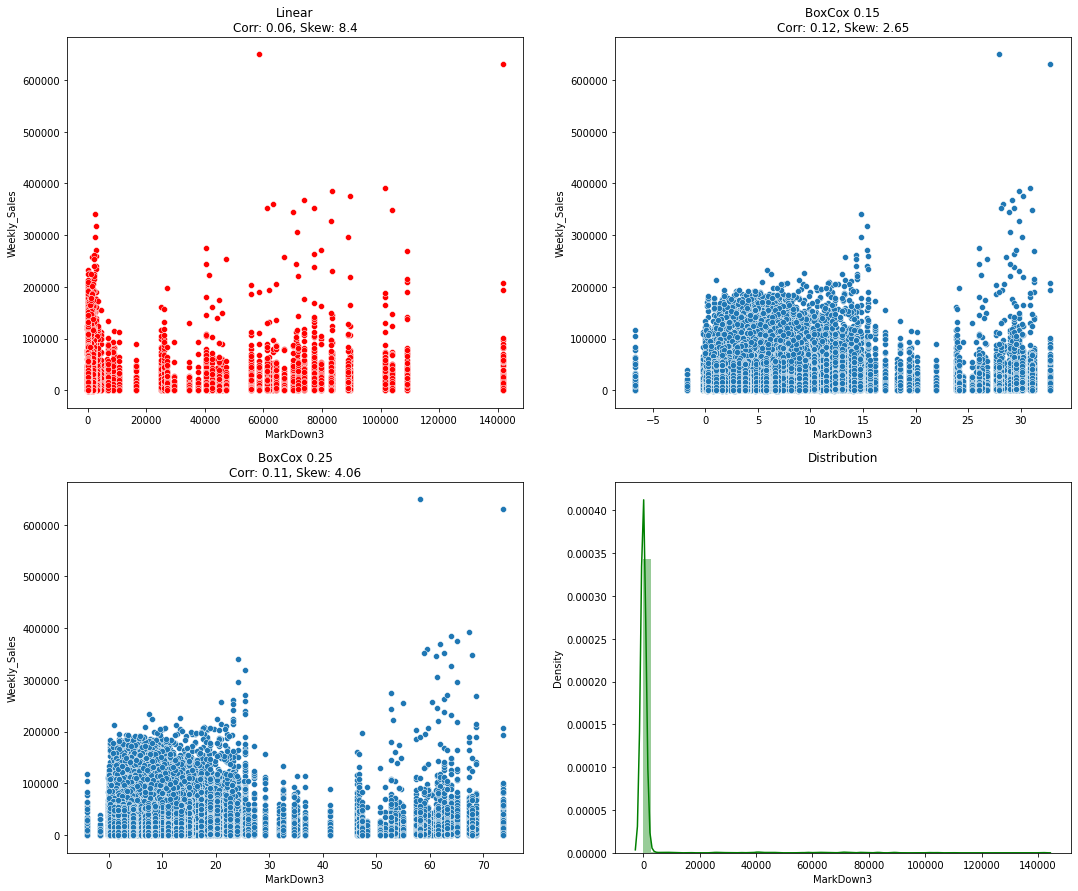

In [34]:
make_continuous_plot('MarkDown3')

MarkDown1と同様

---
Weekly_Sales x MarkDown4

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


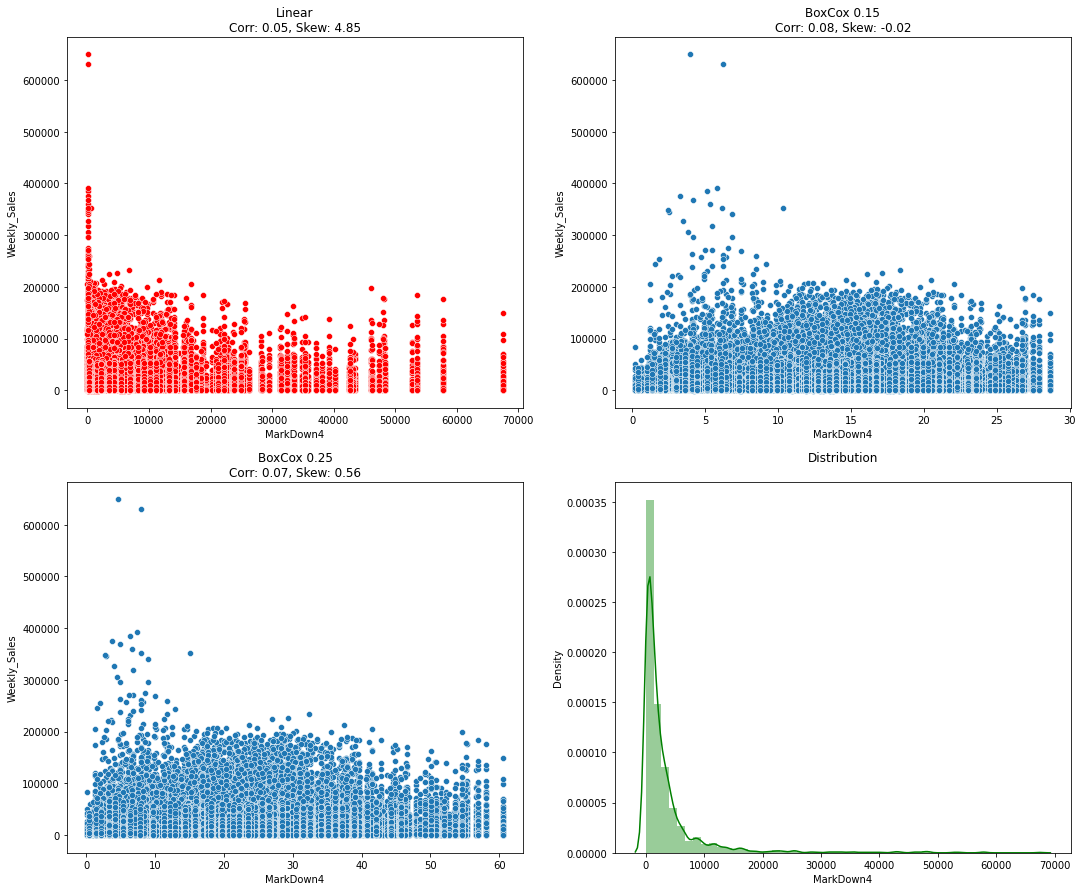

In [35]:
make_continuous_plot('MarkDown4')

MarkDown1と同様

---
Weekly_Sales x MarkDown5

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


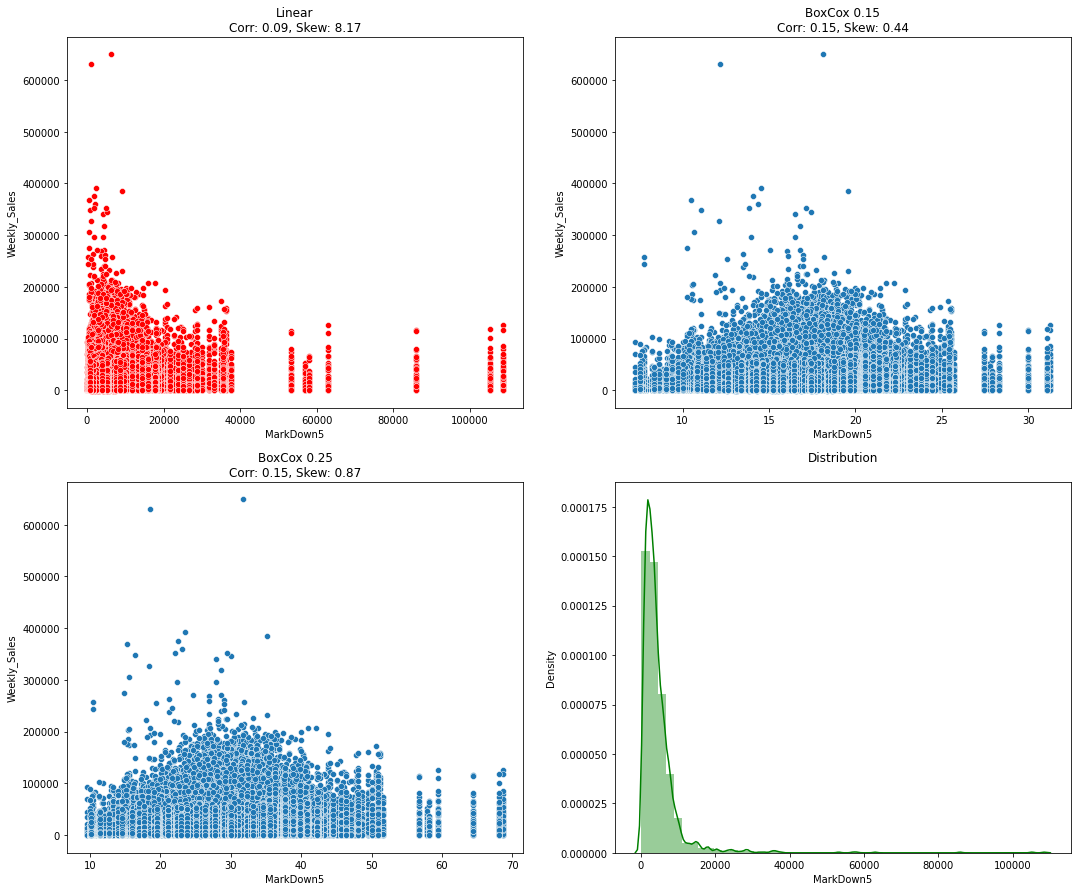

In [36]:
make_continuous_plot('MarkDown5')

MarkDown1と同様

### 2.Weekly_Salesの推移

年・月・週データと'Weekly_Sales'の推移を見る。
まず、Prominent Holiday毎の売り上げに対する傾向を確認するためにProminent Holidayの週番号を確認

In [37]:
#dataframe.dt.week()で週番号を数値化
p_holiday = {'Holiday': ['Super Bowl', 'Super Bowl', 'Super Bowl', 'Super Bowl',
                         'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day',
                         'Thanksgiving','Thanksgiving','Thanksgiving','Thanksgiving', 
                         'Christmas', 'Christmas', 'Christmas', 'Christmas'],
             
             'Date': ["12-Feb-10", "11-Feb-11", "10-Feb-12", "8-Feb-13", 
                      "10-Sep-10", "9-Sep-11", "7-Sep-12", "6-Sep-13", 
                      "26-Nov-10", "25-Nov-11", "23-Nov-12", "29-Nov-13", 
                      "31-Dec-10", "30-Dec-11", "28-Dec-12", "27-Dec-13"]}

df_p_holiday = pd.DataFrame(p_holiday)

df_p_holiday['Date'] = df_p_holiday['Date'].apply(lambda x : datetime.datetime.strptime(x,'%d-%b-%y'))

df_p_holiday['Year'] = df_p_holiday['Date'].dt.year
df_p_holiday['Month'] = df_p_holiday['Date'].dt.month
df_p_holiday['Week'] = df_p_holiday['Date'].dt.week

df_p_holiday

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,Holiday,Date,Year,Month,Week
0,Super Bowl,2010-02-12,2010,2,6
1,Super Bowl,2011-02-11,2011,2,6
2,Super Bowl,2012-02-10,2012,2,6
3,Super Bowl,2013-02-08,2013,2,6
4,Labor Day,2010-09-10,2010,9,36
5,Labor Day,2011-09-09,2011,9,36
6,Labor Day,2012-09-07,2012,9,36
7,Labor Day,2013-09-06,2013,9,36
8,Thanksgiving,2010-11-26,2010,11,47
9,Thanksgiving,2011-11-25,2011,11,47


以下がPriminal Holidayの週番号です。
  - Super Bowl:week 6
  - Labor Day: week 36
  - Thanksgiving: week 47, 48
  - Christmas: week 52

---
週番号とWeekly＿Salesの推移を見る。

In [38]:
weekly_sales_2010 = df[df.Year == 2010]['Weekly_Sales'].groupby(df['Week']).mean()
weekly_sales_2011 = df[df.Year == 2011]['Weekly_Sales'].groupby(df['Week']).mean()
weekly_sales_2012 = df[df.Year == 2012]['Weekly_Sales'].groupby(df['Week']).mean()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


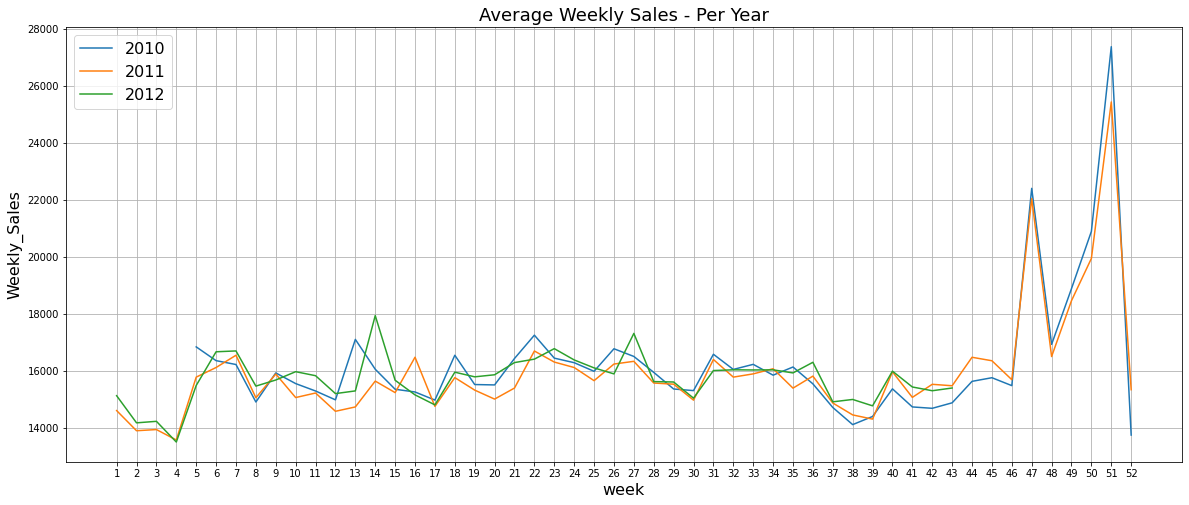

In [39]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.xlabel('week', fontsize=16)
plt.ylabel('Weekly_Sales', fontsize=16)

plt.show()

各Priminal Holidayの週番号を見ると。
  - week 52のChristmasの前のweek 51は、年間で最大の売上高
  - week 47,48のThanksgivingでは、同週のweek 47に売上が過去二位に上がる傾向がある。
  - week6 Super Bowlとweek 36 Labor Dayは一年を通してみると売り上げは高くない。

---
Weekly_Salesの月間推移を見る。

In [40]:
Monthly_sales_2010 = df[df.Year == 2010]['Weekly_Sales'].groupby(df['Month']).mean()
Monthly_sales_2011 = df[df.Year == 2011]['Weekly_Sales'].groupby(df['Month']).mean()
Monthly_sales_2012 = df[df.Year == 2012]['Weekly_Sales'].groupby(df['Month']).mean()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


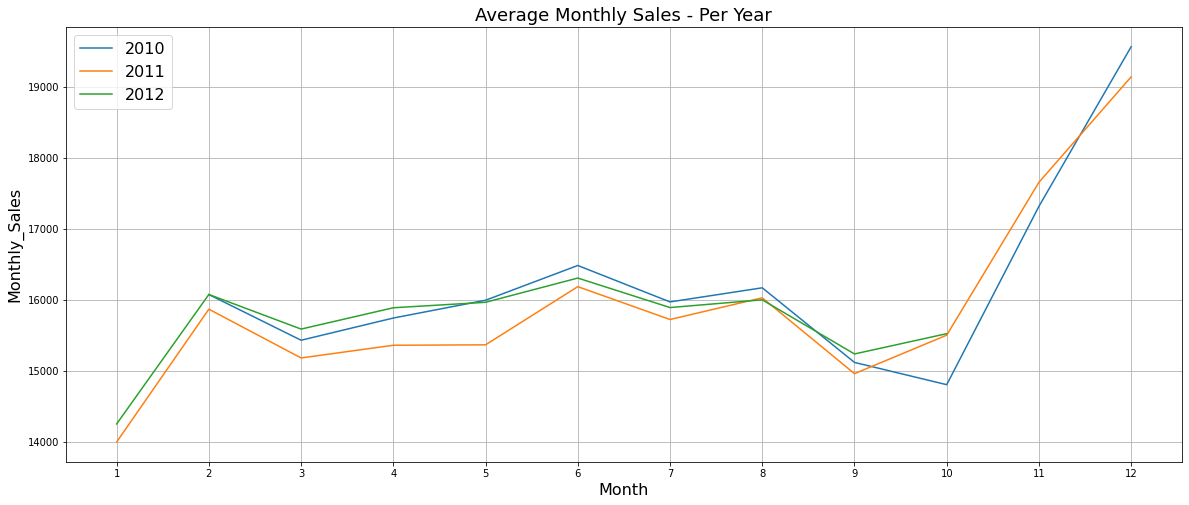

In [41]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(Monthly_sales_2010.index, Monthly_sales_2010.values)
sns.lineplot(Monthly_sales_2011.index, Monthly_sales_2011.values)
sns.lineplot(Monthly_sales_2012.index, Monthly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 13, step=1))
plt.legend(range(1,13), loc='best', fontsize=16)
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Monthly Sales - Per Year', fontsize=18)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Monthly_Sales', fontsize=16)

plt.show()

12月Christmas、11月のThanksgivingで大きく売上が上がることがわかる。

---
### 3.店舗・部門毎のWeekly_Salesの推移

#### 1.'Store'（店舗）ごとのWeekly_Salesの平均値

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


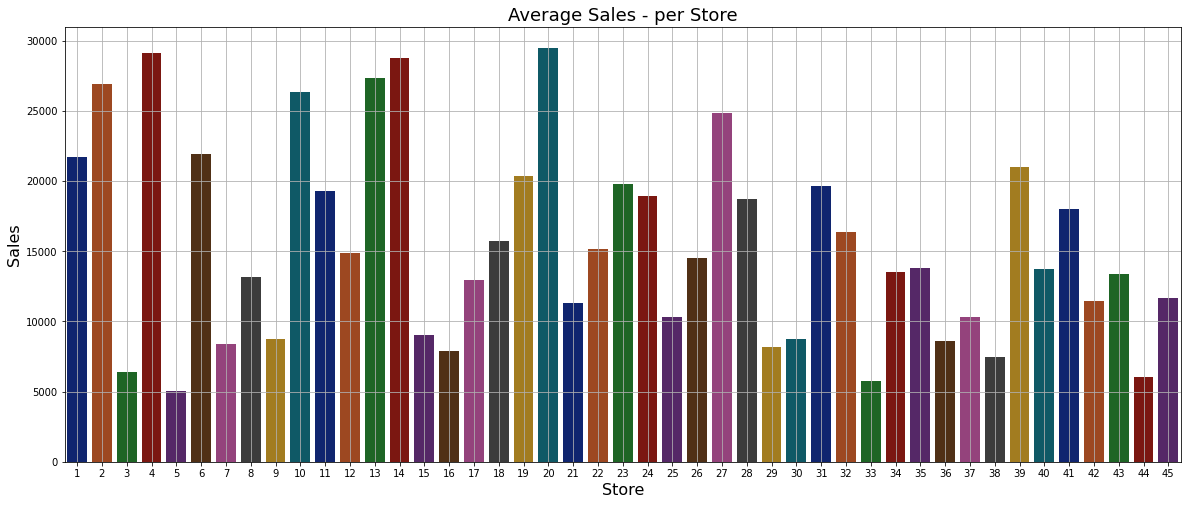

In [42]:
weekly_sales = df['Weekly_Sales'].groupby(df['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

---
#### 2.'Dept'(部門)ごとのWeekly_Salesの平均値

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


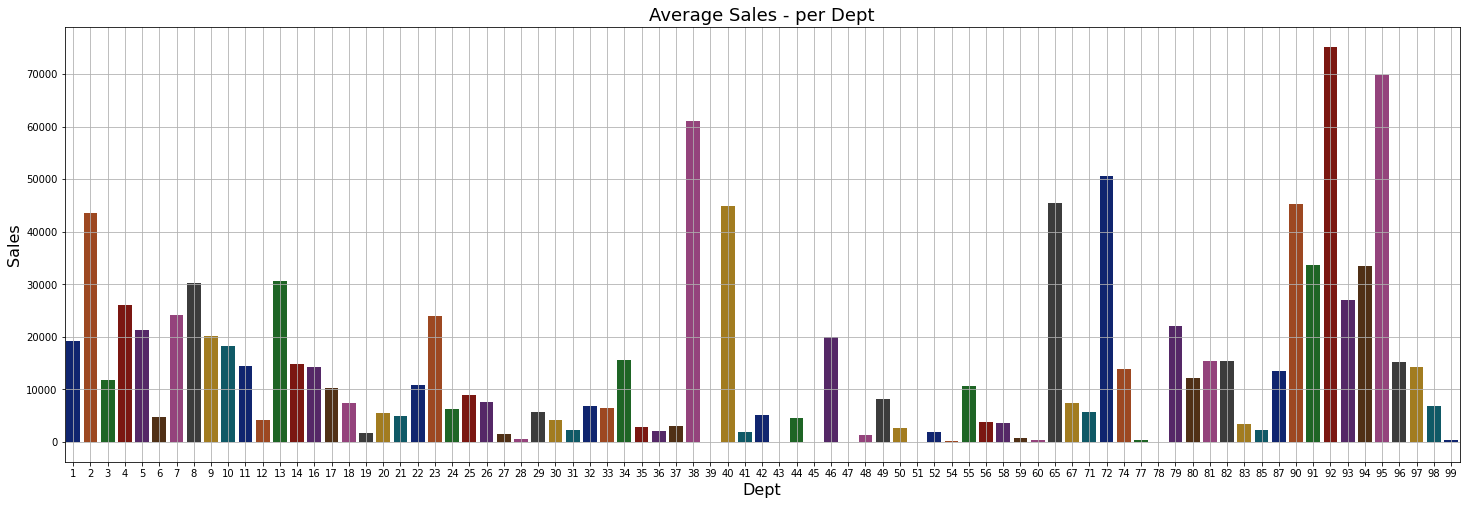

In [43]:
weekly_sales = df['Weekly_Sales'].groupby(df['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

相関関係は見えないが、"Store"店舗ごとで売上が異なったり、"Dept"売り場の部門で売上が異なることがわかる。  
売上が高い店舗として３８、４０、６５、７２、９０〜９５が見れる。

### 4.全特徴量とWeekly_Salesの相関関係

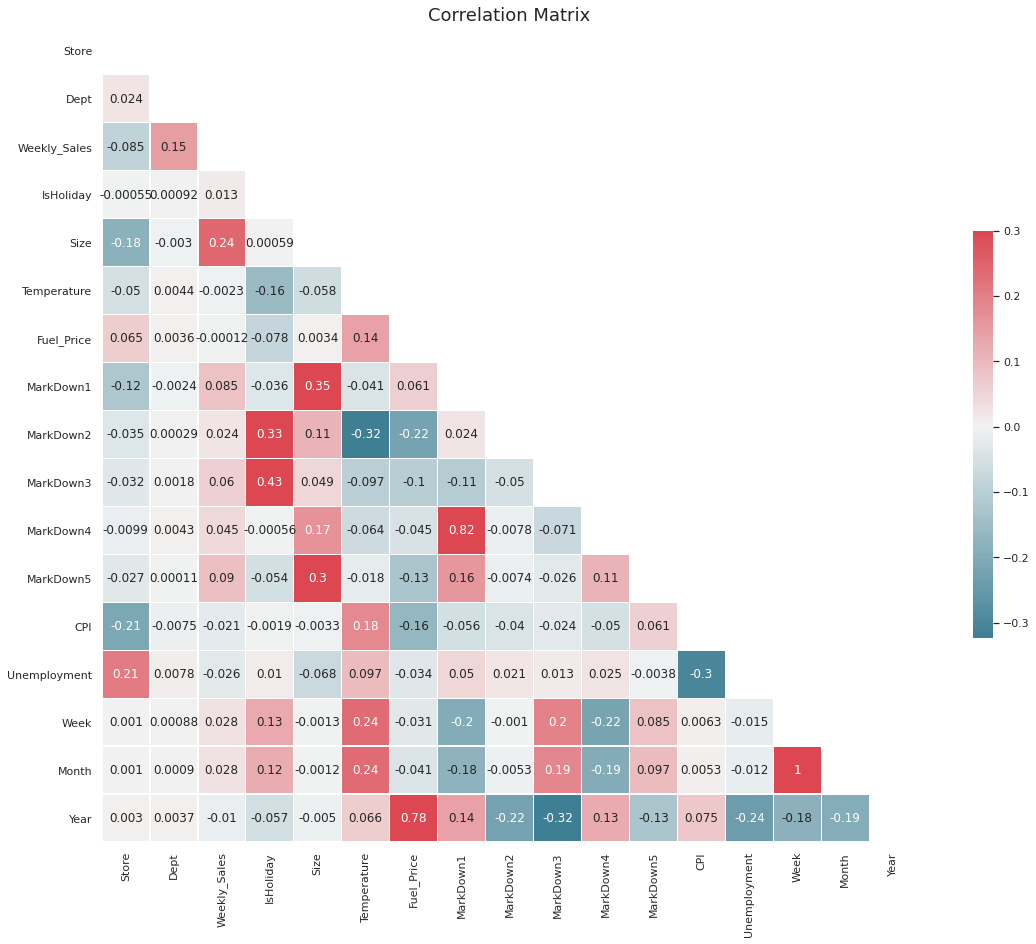

In [44]:
sns.set(style="white")
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

weekly_salesとの相関は、一番高くても'size'が0.24である。  
さらに、MarkDown1-5も相関は低く、2011年11月以降のデータしかないので、削除して予測を立てることも一つの考えだと感じる。

---

### 5.まとめ
データ可視化より、特徴量選択・モデリングの方向性は以下とする。


1. 特徴量選択
  - MarkDown1~5 について
      - 1.売上に相関が見られなかったMarkDownを削除したモデリングを行う。
      - 2.MarkDown1-5を残すために2011年11月以降の売上データのみを用いたモデリングを行う
   - 'Size'：目的変数と相関係数0.24であり、モデルに＋に働く可能性が高い。
   - 'Store', 'Dept'：相関性は弱いが特徴があるデータだった。店舗、部門は、住人の年齢や家族構成のような地域差が見えるデータであり、売上との関係が深いと考えられる。
   -  'Week'(または'Month'):  
   - MarkDownを加える場合については、2011年11月以降のデータしかないため、データ量を減らして、モデリングを行う。


2. モデリング
  - **結論、決定木のような数字を場合わけで振り分けてくれるモデルを採用したい**と考える。特徴量選択より、連続データを使わないモデリングであるため、線形回帰のような相関性を重視するモデルは利用しない事とする。


---
## 4.【モデリング1】MarkDown1-5を削除



### 1.データ前処理
  - 特徴量（列）の削除：
    - 'Date'、'Week'と相関関係数1.0の'Month'
    - 売上との相関が少ないMarkDown1-5
    - 相関係数が低く、さらに分布を作るデータも不十分なFuel_Price、CPI、Temperature、Unemployment
  - データ加工:
    - object型のカラム'Type'を数値へ変換（A→3、B→2、C→1）  

 ※正規化は行わない。ランダムフォレストでは、正規化を行わずにある程度良い結果が出るため。  

---
#### 特徴量（列）の削除
  - 特徴量（列）の削除：
    - 'Date'、'Week'と相関関係数1.0の'Month'
    - 売上との相関が少ないMarkDown1-5
    - 相関係数が低く、さらに分布を作るデータも不十分なFuel_Price、CPI、Temperature、Unemployment

In [45]:
df = df.drop(columns=['Date', 'Fuel_Price', 'CPI', 'Temperature', 'Unemployment','Month','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

In [46]:
df.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Week,Year
0,1,1,24924.50,False,A,151315,5,2010
1,1,2,50605.27,False,A,151315,5,2010


#### object型の特徴量変換
object型のカラム'Type'を数値へ変換（A→3、B→2、C→1）

In [47]:
df['Type'] = df['Type'].apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

In [48]:
pd.DataFrame(df.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Weekly_Sales,float64
IsHoliday,bool
Type,int64
Size,int64
Week,int64
Year,int64


### 2.モデリング（回帰）:
売り上げに相関が見られなかったMarkDown1-5+αを削除したモデリング

#### 0.関数の定義
予測誤差WMAE、予測値・実測値の可視化できる関数を定義する。


##### WMAEの定義

In [49]:
# WMAEの定義
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

##### 予測値の可視化

In [50]:
# 予測値の可視化
def plot_regression_results(y_true, y_pred, title, scores):
    """
    Scatter plot: 予測値とターゲットのプロット
    """
    fig, ax = plt.subplots(figsize=(8.0, 6.0))
    ax = plt.gca()
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc='w', fill=False, edgecolor='none', linewidth=0)

    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)
    plt.show()

#### 1.モデリング①df1
連続データを持つ特徴量を利用しないため、深層学習や線形回帰は利用せず、  
決定木モデルを中心にモデリングを行っていく。  
(モデル：決定木、ランダムフォレスト、XGBoost、LightGBM)

##### 変数の定義
目的変数と説明変数の設定

In [51]:
#目的関数を定義
target = df[["Weekly_Sales"]]

#説明変数（特徴量）を定義
features = df.drop(["Weekly_Sales"], axis=1)

In [52]:
# TestデータとTrainデータへ分割（３割をテストデータへ）
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [53]:
print('x_trainのサイズは、', x_train.shape)
print('x_testのサイズは、', x_test.shape)
print('y_trainのサイズは、', y_train.shape)
print('y_testのサイズは、', y_test.shape)

x_trainのサイズは、 (295099, 7)
x_testのサイズは、 (126471, 7)
y_trainのサイズは、 (295099, 1)
y_testのサイズは、 (126471, 1)


In [54]:
x_test.head(3)

,Store,Dept,IsHoliday,Type,Size,Week,Year
263210,27,29,False,3,204184,43,2011
220125,23,34,True,2,114533,52,2010
335479,35,13,False,2,103681,24,2011


##### KNN
KNNの実装はクラッシュしてしまったため、ベースラインは決定木を利用する。

In [55]:
# クラッシュ
#from sklearn.neighbors import KNeighborsRegressor

#knr = KNeighborsRegressor(n_neighbors=5)
#knr.fit(x_train, y_train)
#y_predicted = knr.predict(x_test)

# WMAEの算出（重さ’weights’はDataframe型）
#WMAE_KNN = WMAE(x_test, y_test.values.ravel(), y_predicted)

In [56]:
#plot_regression_results(y_test.values.ravel(),
#                        y_predicted,
#                        'KNN', 
#                        ('WMAE={:.2f}').format(WMAE_KNN))

##### 決定木回帰
ベースラインとして、決定木を採用する。

In [57]:
from sklearn import tree
dtr = tree.DecisionTreeRegressor(max_depth=30, random_state=42)
DTR = dtr.fit(x_train, y_train.values.ravel())

In [58]:
y_predicted = dtr.predict(x_test)

# WMAEの算出（重さ’weights’はDataframe型）
WMAE_DTR = WMAE(x_test, y_test.values.ravel(), y_predicted)

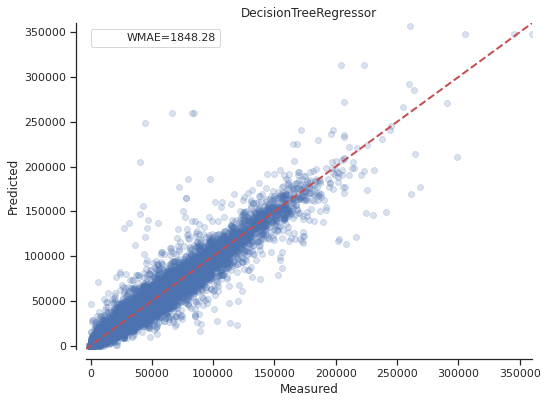

In [59]:
plot_regression_results(y_test.values.ravel(),
                        y_predicted,
                        'DecisionTreeRegressor', 
                        ('WMAE={:.2f}').format(WMAE_DTR))

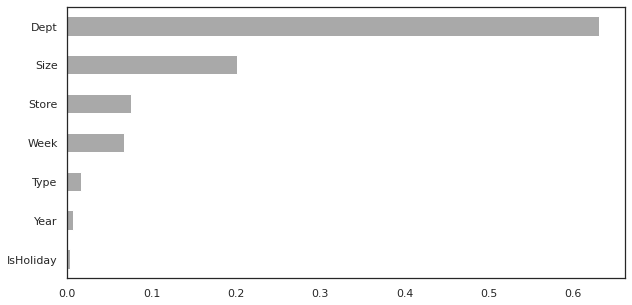

In [60]:
# plot the important features
feat_importances = pd.Series(DTR.feature_importances_, index=features.columns)

fig = plt.figure()

feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))

##### RandomForest回帰

In [61]:
rand_forest = RandomForestRegressor(max_depth=30, n_estimators=30, random_state=42)
#max_depth=30, n_estimators=30, random_state=42

#訓練用データで学習
RFR = rand_forest.fit(x_train, y_train.values.ravel())
#.values.ravel()をy_trainの後につける

rand_forest

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [62]:
# Weekly_Salesの予測
y_predicted = rand_forest.predict(x_test)

# WMAEの算出（重さ’weights’はDataframe型）
WMAE_RFR = WMAE(x_test, y_test.values.ravel(), y_predicted)

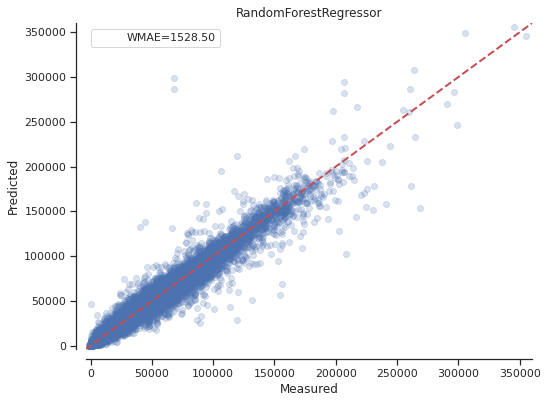

In [63]:
plot_regression_results(y_test.values.ravel(),
                        y_predicted,
                        'RandomForestRegressor', 
                        ('WMAE={:.2f}').format(WMAE_RFR))

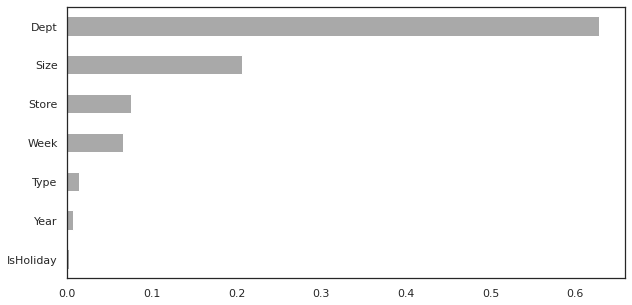

In [64]:
# plot the important features
feat_importances = pd.Series(RFR.feature_importances_, index=features.columns)
fig = plt.figure()
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))

##### XGBoost

In [65]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [66]:
booster = xgb.XGBRegressor(max_depth=30, n_estimators=30, random_state=42)

# train
BST = booster.fit(x_train, y_train.values.ravel())

# predict
y_predicted = booster.predict(x_test)

[09:08:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [67]:
WMAE_XGBOOST = WMAE(x_test, y_test.values.ravel(), y_predicted)

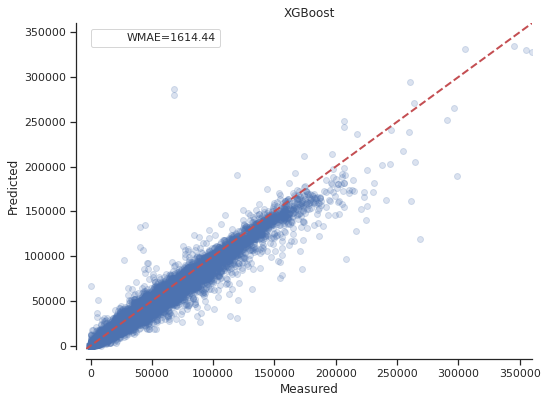

In [68]:
plot_regression_results(y_test.values.ravel(),
                        y_predicted,
                        'XGBoost', 
                        ('WMAE={:.2f}').format(WMAE_XGBOOST))

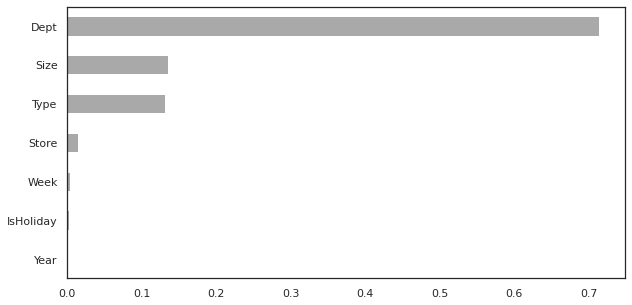

In [69]:
# plot the important features
feat_importances = pd.Series(BST.feature_importances_, index=features.columns)

fig = plt.figure()

feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))

##### Light BGM

In [70]:
from lightgbm import LGBMRegressor

In [71]:
#RandomForestと同じパラメーターを設定
lgbm = LGBMRegressor(max_depth=30, n_estimators=30, random_state=42)

# train
LGBM = lgbm.fit(x_train, y_train.values.ravel())

# predict
y_predicted = lgbm.predict(x_test)

In [72]:
WMAE_LGBM = WMAE(x_test, y_test.values.ravel(), y_predicted)

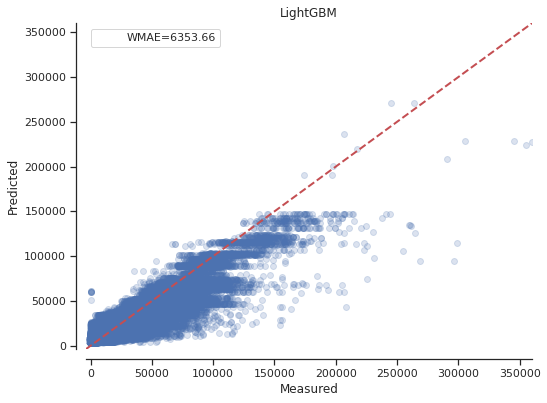

In [73]:
plot_regression_results(y_test.values.ravel(),
                        y_predicted,
                        'LightGBM', 
                        ('WMAE={:.2f}').format(WMAE_LGBM))

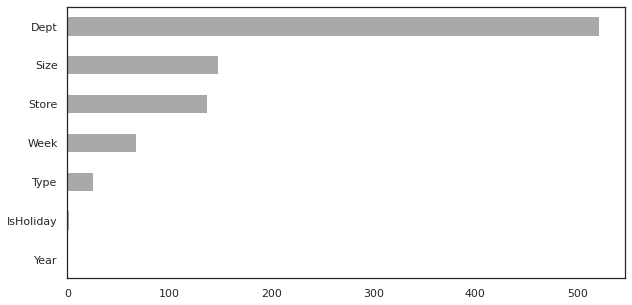

In [74]:
# plot the important features
feat_importances = pd.Series(LGBM.feature_importances_, index=features.columns)

fig = plt.figure()

feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))

### 3.検証：モデル評価とチューニング
交差検証を含むGrid Searchを行い、ハイパーパラメーターの最適化を行う。　　

WMAEが一番小さかったRandamForestRegressorを採用し、Google Colabのスペックの可能な限り、Grid Searchで最適なパラメーターを探す。精度に大きな影響を及ぼすn_estimators（決定木の数）を設定した

In [75]:
#param_grid = {'n_estimators': [100,150,200,250,300],
#              'learning_rate': [0.01,0.05,0.1],
#              'max_depth': [5,6,7],
#              'colsample_bytree': [0.6, 0.7, 1]
#}

# モデリングのサイトは別でデータを分ける。
#x_train_g, x_test_g, y_train_g, y_test_g = train_test_split(features, target, test_size=0.3)

#rand_forest_grid_search = GridSearchCV(rand_forest, param_grid, cv=3, n_jobs=-1)
#rand_forest_grid_search.fit(x_train_g, y_train_g)

In [76]:
#print('Test set score: {}'.format(rand_forest_grid_search.score(x_test_g, y_test_g)))
#print('Best parameters: {}'.format(rand_forest_grid_search.best_params_))
#print('Best cross-validation: {}'.format(rand_forest_grid_search.best_score_))

#以下が、GridSearch結果です。クラッシュしてしまうのでコメントアウトしました。
#Test set score: 0.9742611837680825
#Best parameters: {'n_estimators': 200}
#Best cross-validation: 0.9738704054240372

結果、Best parametersである{'n_estimators': 200}を用いて、ランダムフォレストでモデリングを行い、最終調整をする。

In [77]:
bestmodel_rand_forest = RandomForestRegressor(max_depth=30, n_estimators=200, random_state=42)

#訓練用データで学習
BEST_RFR = bestmodel_rand_forest.fit(x_train, y_train.values.ravel())
#.values.ravel()をy_trainの後につける

In [78]:
# Weekly_Salesの予測
y_predicted = bestmodel_rand_forest.predict(x_test)

# WMAEの算出（重さ’weights’はDataframe型）
BEST_WMAE_RFR = WMAE(x_test, y_test.values.ravel(), y_predicted)

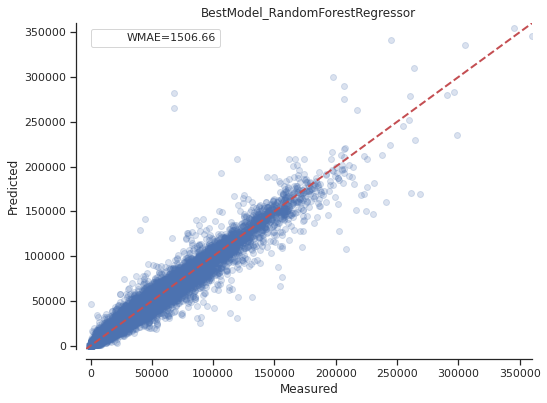

In [79]:
plot_regression_results(y_test.values.ravel(),
                        y_predicted,
                        'BestModel_RandomForestRegressor', 
                        ('WMAE={:.2f}').format(BEST_WMAE_RFR))

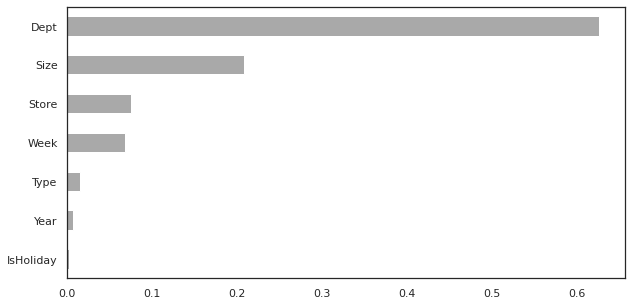

In [80]:
# plot the important features
feat_importances = pd.Series(BEST_RFR.feature_importances_, index=features.columns)

fig = plt.figure()

feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))

結果、ハイパーパラメーターの最適化（n_estimators=30→200へ変更）を行い、約1.6％の改善を行うことができた。（WMAE：1528→1506）  
特徴量の重要度は、上位から見ていくとDept、Size、Store、week、Type、Year、IsHolidayとなった。'Week'は、11月〜12月にガツッと上昇していくような特徴的な売上推移から重要な特徴量だと考えたが重要度は低い結果となった。  

今回の結果に対する考察と改善案を以下に示した。
  - 部門'Dept'は、売上が高い店舗番号がバラバラであったため、モデルの際に複雑な予測をしてしまったと考えられる。改善としては、①One-Hot Encoding、②ランキングに並べて、再度ラベル付を行うが考えられる。
  - 'Size'は、'Store'店舗のサイズを表し、部門問わず同じ番号を結合してしているので削除しても精度は変わらないので計算コストを考え削除する。
  - 'Store'店舗も、'Dept'と同じ対応
  - 'Week'は、このままで良いと考えます。週番号で売上の傾向はわかるので時系列データでの深層学習は必要ないと考える。
  - 大量のデータを扱うことができるRAPIDSを活用し、ランダムフォレストを行う。

## Ⅲ. まとめ
今回は、データセットにはモデリングに利用できそうな特徴量が少なかったため、  
深層学習や線形回帰は利用せず、決定木モデルを中心にモデリングを行った。  
(利用したモデル：決定木、ランダムフォレスト、XGBoost、LightGBM)
  
結果、**最適なモデルランダムフォレスト＋GridSearchを用いて、損失関数WMAE:1506**の結果を出すことができた。  
しかし、モデルの検証に記した前処理で改善することでより精度は上がってくると考え、改善の余地は多いと感じています。  
  
出題者が求めているMarkDown1~5を利用したモデリングができていないのでモデリング２で行うことを考えております。  
個人的にGoogle ColabのスペックやM1 Mac PCの不具合でクラッシュしてしまうことが多く、計算量を考えながらのデータ処理を意識していきたいと思います。

参考
  - データ可視化：https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting
  - 前処理：https://ishitonton.hatenablog.com/entry/2019/02/24/184253
